# Hidden Markov Model for Pathfinding

# References

In [1]:
#I acknowledge that this work is my own, and I have used ChatGPT 4 (OpenAI, https://chat.openai.com/) to
#rectify few of my errors in the code and also in some places where I had doubts in the code that I have explicitly mentioned in the codes below.

In [2]:
# Codes Adapted from:

# 1. Grid Representation - 
#    W3Schools is Powered by W3.CSS, Matplotlib Adding Grid Lines [computer program], 
#    Available from: https://www.w3schools.com/python/matplotlib_grid.asp

# 2. Forward Pass - 
#    AzharuddinKazi, Forward-Algorithm-HMM [computer program], 
#    Available from: https://github.com/AzharuddinKazi/Forward-Algorithm-HMM/blob/master/Forward_Algorithm_HMM.py

# 3. Baum-Welch-Algorithm -  
#    A Developer Diary, Abhisek Jana, Derivation and implementation of Baum Welch Algorithm for Hidden Markov Model [computer program], 
#    Available from: https://www.adeveloperdiary.com/data-science/machine-learning/derivation-and-implementation-of-baum-welch-algorithm-for-hidden-markov-model/

# 4. Viterbi Agorithm - 
#    Pierian Training, Viterbi Algorithm Implementation in Python: A Practical Guide [computer program], 
#    Available from: https://pieriantraining.com/viterbi-algorithm-implementation-in-python-a-practical-guide/#:~:text=It%20is%20used%20for%20finding,apply%20it%20to%20our%20problem.

# 5. State Probabilties - projectrhea.org, Python Demonstration [computer program], 
#    Available from: https://www.projectrhea.org/rhea/index.php/Python_Demonstration

# 6. OpenStreetMap and openrouteservice API and also with the help of ChatGPT- 
       # --> Just Need a Map, How to add real-time traffic data to a map using Python and OpenStreetMap API [computer program],
       #     Available from: https://justneedamap.com/how-to-add-real-time-traffic-data-to-a-map-using-python-and-openstreetmap-api/
       # --> OpenStreetMap, © Crown copyright and database right 2010-2023, Available from: https://www.openstreetmap.org/export#map=16/51.3804/-2.3543
       # --> © 2021 openrouteservice, Available from: https://api.openrouteservice.org/
       # --> openrouteservice, optimize your pub crawl with openrouteservice [computer program], 
       #     Available from: https://openrouteservice.org/example-optimize-pub-crawl-with-ors/
       # Logitudes and Latitudes
       # --> Available from: © Latitude.to (v1.64-im ) 2024,  Available from: https://latitude.to/articles-by-country/gb/united-kingdom/4488/university-of-bath
       # --> Available from: © Latitude.to (v1.64-im ) 2024, Available from: https://latitude.to/articles-by-country/gb/united-kingdom/9780/bath-abbey
       # https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.patches import FancyArrowPatch
import folium
import requests  # For making HTTP requests to the routing API

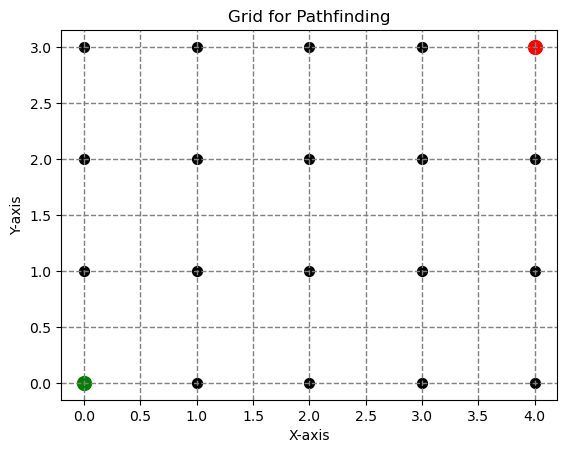

In [2]:
# Grid Representation [1]
plt.title("Grid for Pathfinding")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Define the start and end points for a 4x5 grid
start_point = (0, 0)
end_point = (3, 4) 

# Dimensions for the grid
rows = 4  # Number of rows
columns = 5  # Number of columns

# Generate each point on the grid - (x,y)
grid = list(itertools.product(range(rows), range(columns)))
plt.grid(True, color='grey', linestyle='--', linewidth=1)

# Plot the vertices
# matplotlib.axes.Axes.scatter, Available from: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html
for vertex in grid:
    plt.scatter(vertex[1], vertex[0], color='black', s=50)  

# Plot the start and end points
plt.scatter(start_point[1], start_point[0], color='green', s=100, label='Start')  
plt.scatter(end_point[1], end_point[0], color='red', s=100, label='End')  


plt.show()

# Representation of Initial Transition Matrix

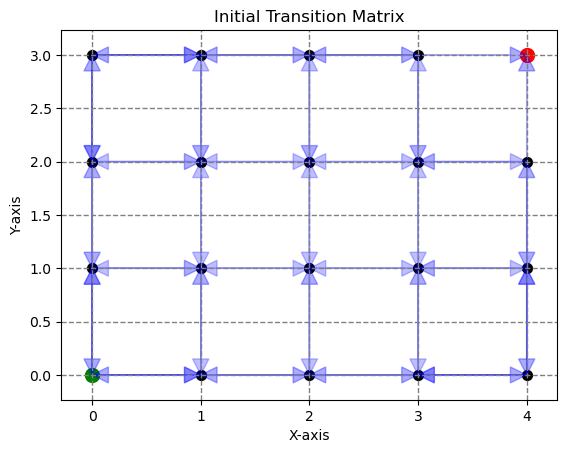

In [3]:
plt.title("Grid for Pathfinding")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Define the start and end points for a 4x5 grid
start_point = (0, 0)
end_point = (3, 4) 

# Dimensions for the grid
rows = 4  # Number of rows
columns = 5  # Number of columns

# Generate each point on the grid - (x,y)
grid = list(itertools.product(range(rows), range(columns)))
plt.grid(True, color='grey', linestyle='--', linewidth=1)

# Plot the vertices
for vertex in grid:
    plt.scatter(vertex[1], vertex[0], color='black', s=50)  # Swap x and y for plotting

# Plot the start and end points
plt.scatter(start_point[1], start_point[0], color='green', s=100, label='Start')  # Swap x and y for plotting
plt.scatter(end_point[1], end_point[0], color='red', s=100, label='End')  # Swap x and y for plotting

# Function to get the index of a state in the grid
def state_index(state, rows, columns):
    return state[0] * columns + state[1]

# Convert state index to grid coordinates
def state_to_coord(index, rows, columns):
    return (index % columns, index // columns)

# Define the transition matrix A for the Markov model
N = rows * columns  # Total number of states
A = np.zeros((N, N))

# Transition probabilities for each vertex - asked ChatGPT
for i in range(rows):
    for j in range(columns):
        current_state = (i, j)
        current_index = state_index(current_state, rows, columns)

        if current_state == end_point:
            # For the destination state, set aωω = 1
            A[current_index, current_index] = 1
        else:
            # Get the list of neighboring states (up, down, left, right)
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
            # Filter out neighbors that are outside the grid
            valid_neighbors = [n for n in neighbors if 0 <= n[0] < rows and 0 <= n[1] < columns]
            # Set the transition probabilities to be uniform across neighbors
            if valid_neighbors:
                for neighbor in valid_neighbors:
                    neighbor_index = state_index(neighbor, rows, columns)
                    A[current_index, neighbor_index] = 1 / len(valid_neighbors)
                    
# Normalize each row so that probabilities sum to 1
# numpy.sum, Available from: https://numpy.org/doc/stable/reference/generated/numpy.sum.html           
A /= np.sum(A, axis=1, keepdims=True)    

# Define the prior state distribution with the starting point set to 1
pi = np.zeros(N)
pi[state_index(start_point, rows, columns)] = 1

# Correct definition of the cost vector b
costs = np.ones(N)
costs[state_index(end_point, rows, columns)] = 0
b = np.exp(-costs)  # Convert costs to probabilities
                    

# Show the plot - asked GPT
plt.title("Initial Transition Matrix")
for i in range(N):
    # Convert state index back to grid coordinates for plotting
    x, y = state_to_coord(i, rows, columns)
    
    for j in range(N):
        if A[i, j] > 0:
            # Convert destination state index back to grid coordinates
            nx, ny = state_to_coord(j, rows, columns)
            
            # Draw the arrow from (x_plot, y_plot) to (nx_plot, ny_plot)
            plt.arrow(x, y, nx - x, ny - y, color='blue', alpha=A[i, j], 
                      length_includes_head=True, head_width=0.15, head_length=0.15)


plt.show()

In [5]:
# Forward Pass [2] and Baum-Welch-Algorithm [3]  

# Baum-Welch-Algorithm for HMM

In [6]:
class HMM_Forward_Backward:
    
    def forward_pass(self,A, pi, b,T):
        """ Forward pass algorithm for HMM.
    
        A: Transition matrix.
        pi: Initial state distribution.
        b: Emission probability (cost of each vector).
        T: Number of steps in the model.
        Returns: Alpha matrix containing forward probabilities and “likelihood” of the “observations”.
        """
        N = A.shape[0]  # Number of states
        
        alpha = np.zeros((N, T))
        
        epsilon = 1e-10  # Small constant to prevent log(0)
        scaling_factors = np.zeros(T)  # Initialize scaling factors

        # Initialize alpha values at step 0
        alpha[:, 0] = pi * b

        # Compute alpha values for each time step
        for t in range(1,T):
            for j in range(N):
                alpha[j, t] = np.sum(alpha[:, t-1] * A[:, j]) * b[j]
                
            scaling_factors[t] = np.sum(alpha[:, t]) 
            alpha[:, t] /= scaling_factors[t]  # Scale alpha values 

        # Compute log likelihood
        log_likelihood = np.sum(np.log(scaling_factors + epsilon))

        return alpha, log_likelihood

    def backward_pass(self,A, b,T):
        """
         Backward pass algorithm for HMM.
    
         Parameters:
         A: Transition matrix.
         b: Emission probability (cost of each vector).
         T: Number of steps in the model.
         Returns: Beta matrix containing backward probabilities.
        """
        N = A.shape[0]
       
        epsilon = 1e-10  # Small constant to prevent log(0)
        
        beta = np.zeros((N, T))

        # Initialization
        beta[:, T-1] = 1

        # Compute beta values for each time step
        for t in range(T-2, -1, -1):
            for i in range(N):
                beta[i, t] = np.sum(A[i, :] * b[i] * beta[:, t+1])
                
            beta[:, t] /= np.sum(beta[:, t+1]) + epsilon  # Scale beta values

        return beta

    def compute_gamma(self,alpha, beta, A, T):
        """
        Compute the gamma matrix for a Hidden Markov Model.
    
        alpha:  Alpha matrix from the forward pass.
        beta: Beta matrix from the backward pass.

        Returns: Gamma matrix containing the probability of being in each state at each time step.
        """
        N = A.shape[0]  
      
        gamma = np.zeros((N, T))

        for t in range(T):
            denominator = np.sum(alpha[:, t] * beta[:, t])
            for i in range(N):
                numerator = alpha[i, t] * beta[i, t]
                
                gamma[i, t] = numerator / denominator

        return gamma

    def compute_xi(self,alpha, beta, A, b,T):
        """
        Compute the Xi matrix for a Hidden Markov Model.

        alpha: Alpha matrix from the forward pass.
        beta: Beta matrix from the backward pass.
        A: Transition matrix.
        b: Emission probability vector.
        T: Total number of time steps.

        Returns: Xi matrix containing the joint probability of transitions between states at each time step.
        """
        N = A.shape[0]
       
        xi = np.zeros((N, N, T-1))

        for t in range(T-1):  
            denominator = np.sum(alpha[:, t] * A * b * beta[:, t+1])
            for i in range(N):
                numerator = alpha[i, t] * A[i, :] * b * beta[:, t+1] 
                                        
                xi[i, :, t] = numerator / denominator

        return xi


    def update_transition_matrix(self,xi, gamma, T):
        """
        Update the transition matrix A using xi and gamma.

        Parameters:
        xi: Xi matrix containing the joint probability of transitions between states at each time step.
        gamma: Gamma matrix containing the probability of being in each state at each time step.

        Returns: Updated transition matrix A.
        """
        N = xi.shape[0]
        
        A_updated = np.zeros((N, N))

        for i in range(N):
            denominator = np.sum(gamma[i, :T-1]) 
            for j in range(N):
                numerator = np.sum(xi[i, j, :T-1])  
                
                if denominator == 0:
                    A_updated[i, j] = 0  # Avoid division by zero
                
                A_updated[i, j] = numerator / denominator
                
        # Normalize to ensure rows of A sum to 1
        A_updated /= np.sum(A_updated, axis=1, keepdims=True)
 
        return A_updated

   # Viterbi Algorithm [4]
    def viterbi_algorithm(self, A, pi, b,T,end_state,max_repeats=1):
        """
        Viterbi algorithm for finding the most likely sequence of hidden states.
        
        Returns: Most likely sequence of states.
        """
        N = A.shape[0]
        viterbi = np.zeros((N, T))
        backpointer = np.zeros((N, T), dtype=int)
        

        # Initialize
        viterbi[:, 0] = pi * b
        backpointer[:, 0] = 0

        end_state_count = 0  # Counter for repetitions of end_state

        # Recursion step
        for t in range(1, T):
            for s in range(N):
                transition_probs = viterbi[:, t-1] * A[:, s]
                max_prob = np.max(transition_probs)
                best_prev_state = np.argmax(transition_probs)
                viterbi[s, t] = max_prob * b[s]
                backpointer[s, t] = best_prev_state

        # Check if current state is repeatedly the end_state
            current_best = np.argmax(viterbi[:, t])
            if current_best == end_state:
                end_state_count += 1
            else:
                end_state_count = 0  

            # Early termination 
            if end_state_count >= max_repeats:
                T = t + 1  
                break

         # Termination step
        best_last_state = np.argmax(viterbi[:, T-1])
        best_path_prob = viterbi[best_last_state, T-1]

        # Path reconstruction
        best_path = [best_last_state]
        for t in range(T-1, 0, -1):
            best_path.insert(0, backpointer[best_path[0], t])

        return best_path



[-34.21117521 -30.22089051 -30.04984996 -30.02902469 -30.02627745
 -30.02590851 -30.02585871 -30.02585198 -30.02585107 -30.02585095
 -30.02585093 -30.02585093 -30.02585093 -30.02585093 -30.02585093
 -30.02585093 -30.02585093 -30.02585093 -30.02585093 -30.02585093
 -30.02585093 -30.02585093 -30.02585093 -30.02585093 -30.02585093
 -30.02585093 -30.02585093 -30.02585093 -30.02585093 -30.02585093
 -30.02585093 -30.02585093 -30.02585093 -30.02585093 -30.02585093
 -30.02585093 -30.02585093 -30.02585093 -30.02585093 -30.02585093
 -30.02585093 -30.02585093 -30.02585093 -30.02585093 -30.02585093
 -30.02585093 -30.02585093 -30.02585093 -30.02585093 -30.02585093]


Text(0, 0.5, 'Log Probability')

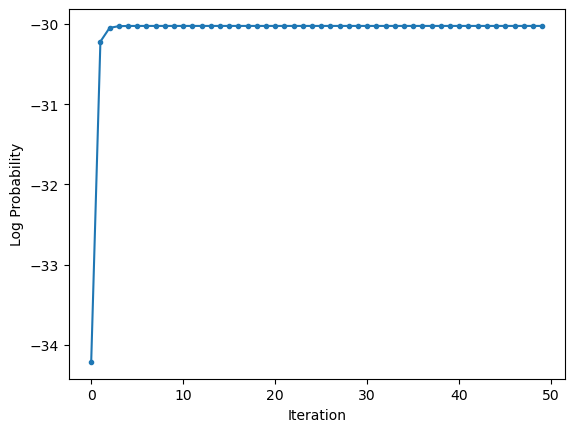

In [7]:
T = 25
num_its = 50
# Initialize the HMM class
# Code from Supervisor
fb = HMM_Forward_Backward()
likelihood_it = np.empty(num_its)

for it in range(num_its):
    
    # Calculate forward and backward passes with scaling
    alpha_values, log_likelihood = fb.forward_pass(A, pi, b,T)
    likelihood_it[it] = log_likelihood
    beta_values = fb.backward_pass(A, b,T)

    # Compute gamma and xi
    gamma = fb.compute_gamma(alpha_values, beta_values, A,T)
    xi = fb.compute_xi(alpha_values, beta_values, A, b,T)

    # Update the transition matrix
    A_new = fb.update_transition_matrix(xi, gamma,T)
    A = A_new

print(likelihood_it)
plt.plot(likelihood_it, '.-')
plt.xlabel("Iteration")
plt.ylabel("Log Probability")


In [8]:
#Viterbi algorithm to find the optimal, minimum cost path
def coord_to_state(coord, rows, columns):
    return coord[0] * columns + coord[1]

end_state = coord_to_state(end_point, rows, columns)

best_path  = fb.viterbi_algorithm(A_new, pi, b,T,end_state)

# Heatmap of Optimized Transition Matrix

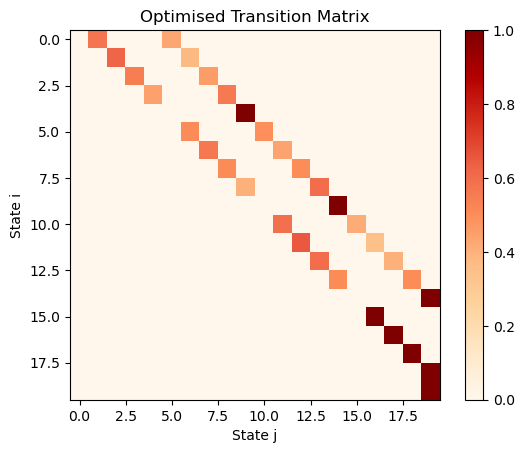

In [9]:
# Create a heatmap
plt.imshow(A_new, cmap='OrRd')
plt.colorbar()  # Show a color bar to indicate the scale
plt.title('Optimised Transition Matrix')
plt.xlabel('State j')
plt.ylabel('State i')
plt.show()

# Optimized Transition Matrix

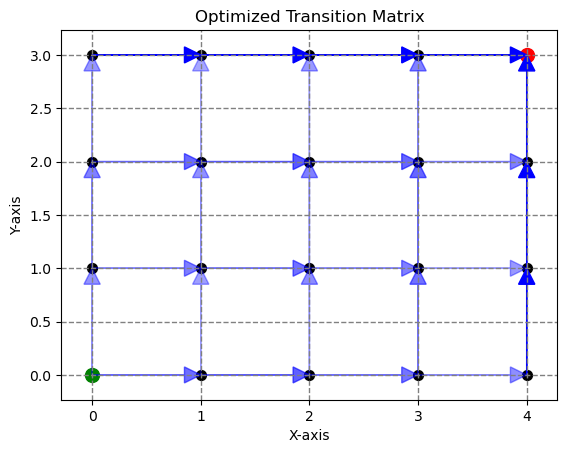

In [10]:
plt.title("Grid for Pathfinding")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Define the start and end points for a 4x5 grid
start_point = (0, 0)
end_point = (3, 4) 

# Dimensions for the grid
rows = 4  # Number of rows
columns = 5  # Number of columns

# Generate each point on the grid - (x,y)
grid = list(itertools.product(range(rows), range(columns)))
plt.grid(True, color='grey', linestyle='--', linewidth=1)

# Plot the vertices
for vertex in grid:
    plt.scatter(vertex[1], vertex[0], color='black', s=50)  

# Plot the start and end points
plt.scatter(start_point[1], start_point[0], color='green', s=100, label='Start')  
plt.scatter(end_point[1], end_point[0], color='red', s=100, label='End')  


# Convert state index to grid coordinates
def state_to_coord(index, rows, columns):
    return (index % columns, index // columns)

N = rows * columns  # Total number of states    

# Show the plot - asked GPT
plt.title("Optimized Transition Matrix")
for i in range(N):
    # Convert state index back to grid coordinates for plotting
    x, y = state_to_coord(i, rows, columns)
    
    for j in range(N):
        if A_new[i, j] > 0:
            # Convert destination state index back to grid coordinates
            nx, ny = state_to_coord(j, rows, columns)
            
            # Draw the arrow from (x_plot, y_plot) to (nx_plot, ny_plot)
            plt.arrow(x, y, nx - x, ny - y, color='blue', alpha=A_new[i, j], 
                      length_includes_head=True, head_width=0.15, head_length=0.15)

plt.show()


# State Probabilities

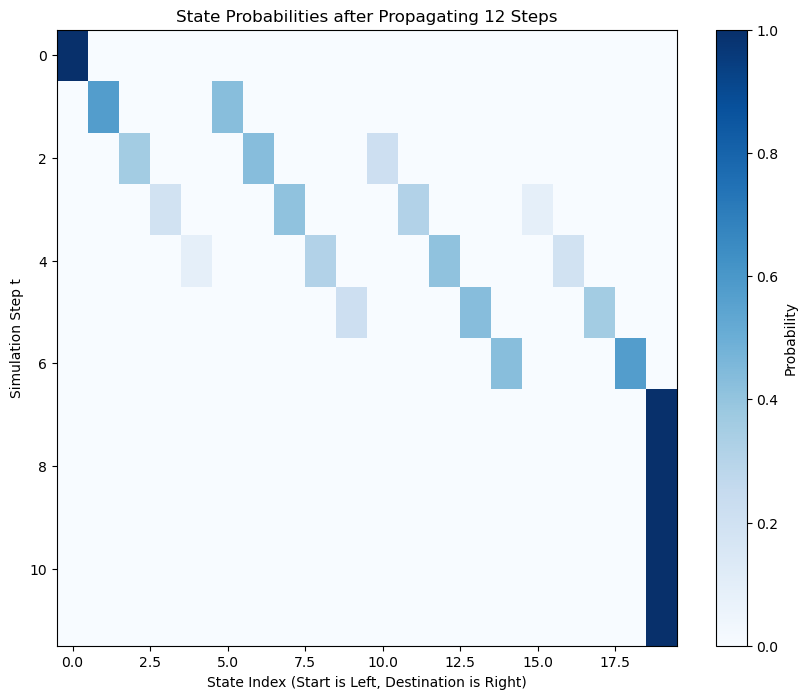

In [11]:
# Set the number of steps
n_steps = 12
n_states = rows * columns

# Initialize the state probabilities for each step
state_probabilities = np.zeros((n_steps, n_states))

# Set the initial state probabilities (assuming we start from state 0)
state_probabilities[0, 0] = 1

# Propagate the state probabilities through the Markov chain  - State Probabilties [5]
for step in range(1, n_steps):
    # Update the state probabilities for the current step
    state_probabilities[step] = np.dot(state_probabilities[step - 1], A_new)

# Create a heat map for the state probabilities after n_steps - asked ChatGPT for the plotting
plt.figure(figsize=(10,8))
plt.imshow(state_probabilities, cmap='Blues', aspect='auto')

plt.colorbar(label='Probability')
plt.title('State Probabilities after Propagating {} Steps'.format(n_steps))
plt.xlabel('State Index (Start is Left, Destination is Right)')
plt.ylabel('Simulation Step t')
plt.show()



# Sampling Routes

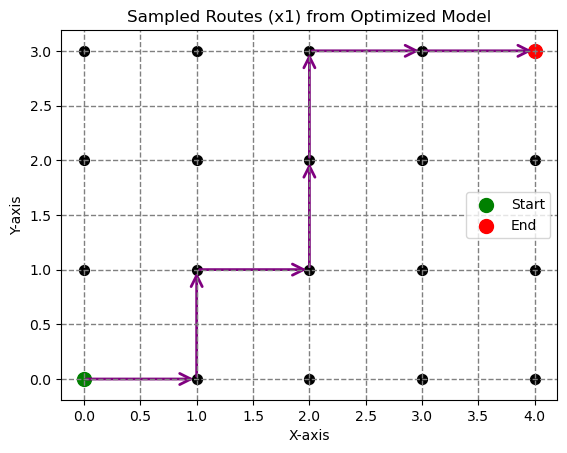

In [14]:
# Define the grid dimensions for a 4x5 grid
rows, columns = 4, 5

# Generate each point on the grid - (x,y)
grid = list(itertools.product(range(rows), range(columns)))

# Define the start and end points as grid coordinates
start_point = (0, 0)  
end_point = (3, 4)  

# Plot the vertices
for vertex in grid:
    plt.scatter(vertex[1], vertex[0], color='black', s=50)  

# Plot the start and end points
plt.scatter(start_point[1], start_point[0], color='green', s=100, label='Start')  
plt.scatter(end_point[1], end_point[0], color='red', s=100, label='End') 

# Convert state index to grid coordinates for a 4x5 grid
def state_to_coord(state, rows, columns):
    return (state % columns, state // columns)

# Convert grid coordinates to state index for a 4x5 grid
def coord_to_state(coord, rows, columns):
    return coord[1] * columns + coord[0]


# Convert the start and end points to state indices
start_state = coord_to_state(start_point, rows, columns)
end_state = coord_to_state(end_point, rows, columns)


# Function to simulate paths on the grid using the optimized transition matrix
def simulate_path(A_new, start_state, end_state, rows, columns):
    current_state = start_state
    path = [current_state]
    
    T = 12  # Maximum number of steps in a path
    for _ in range(T - 1):
        next_state = np.random.choice(len(A_new), p=A_new[current_state])
        path.append(next_state)
        current_state = next_state
        if current_state == end_state:
            break
    return path

# Simulate multiple paths
num_paths = 1
paths = [simulate_path(A_new, start_state, end_state, rows, columns) for _ in range(num_paths)]

# Plot the grid
plt.grid(True, color='grey', linestyle='--', linewidth=1)
plt.title("Sampled Routes (x{}) from Optimized Model".format(num_paths))
plt.xlabel("X-axis")
plt.ylabel("Y-axis")


# Plot the paths with arrows - asked GPT

for path in paths:
    coords = np.array([state_to_coord(state, rows, columns) for state in path])
    for i in range(len(coords)-1):
        start_coord = coords[i]  
        end_coord = coords[i+1]
        arrow = FancyArrowPatch(start_coord, end_coord, arrowstyle='->', mutation_scale=20, color='purple', linewidth=2)
        plt.gca().add_patch(arrow)


plt.legend()
plt.show()



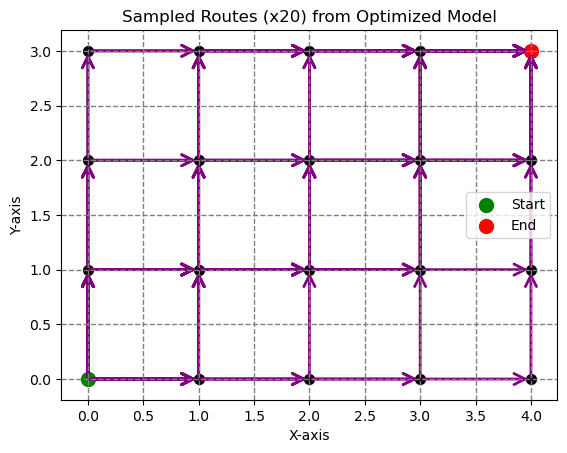

In [15]:
# Define the grid dimensions for a 4x5 grid
rows, columns = 4, 5

# Generate each point on the grid - (x,y)
grid = list(itertools.product(range(rows), range(columns)))

# Define the start and end points as grid coordinates
start_point = (0, 0)  
end_point = (3, 4)  

# Plot the vertices
for vertex in grid:
    plt.scatter(vertex[1], vertex[0], color='black', s=50)  

# Plot the start and end points
plt.scatter(start_point[1], start_point[0], color='green', s=100, label='Start')  
plt.scatter(end_point[1], end_point[0], color='red', s=100, label='End') 

# Convert state index to grid coordinates for a 4x5 grid
def state_to_coord(state, rows, columns):
    return (state % columns, state // columns)

# Convert grid coordinates to state index for a 4x5 grid
def coord_to_state(coord, rows, columns):
    return coord[1] * columns + coord[0]


# Convert the start and end points to state indices
start_state = coord_to_state(start_point, rows, columns)
end_state = coord_to_state(end_point, rows, columns)


# Function to simulate paths on the grid using the optimized transition matrix
def simulate_path(A_new, start_state, end_state, rows, columns):
    current_state = start_state
    path = [current_state]
    
    T = 12  # Maximum number of steps in a path
    for _ in range(T - 1):
        next_state = np.random.choice(len(A_new), p=A_new[current_state])
        path.append(next_state)
        current_state = next_state
        if current_state == end_state:
            break
    return path

# Simulate multiple paths
num_paths = 20
paths = [simulate_path(A_new, start_state, end_state, rows, columns) for _ in range(num_paths)]

# Plot the grid
plt.grid(True, color='grey', linestyle='--', linewidth=1)
plt.title("Sampled Routes (x{}) from Optimized Model".format(num_paths))
plt.xlabel("X-axis")
plt.ylabel("Y-axis")


# Plot the paths with arrows - asked GPT

for path in paths:
    coords = np.array([state_to_coord(state, rows, columns) for state in path])
    for i in range(len(coords)-1):
        start_coord = coords[i]  
        end_coord = coords[i+1]
        arrow = FancyArrowPatch(start_coord, end_coord, arrowstyle='->', mutation_scale=20, color='purple', linewidth=2)
        plt.gca().add_patch(arrow)


plt.legend()
plt.show()


# Optimal Path - Viterbi Algorithm

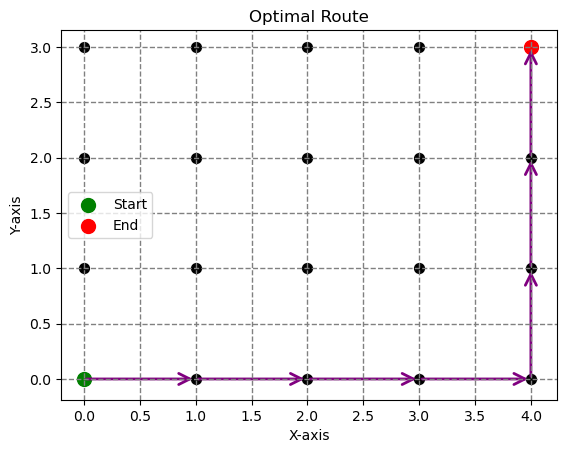

In [16]:
# Define the grid dimensions for a 4x5 grid
rows, columns = 4, 5

# Generate each point on the grid - (x,y)
grid = list(itertools.product(range(rows), range(columns)))

# Define the start and end points as grid coordinates
start_point = (0, 0)  
end_point = (3, 4)  

# Plot the vertices
for vertex in grid:
    plt.scatter(vertex[1], vertex[0], color='black', s=50)  

# Plot the start and end points
plt.scatter(start_point[1], start_point[0], color='green', s=100, label='Start')  
plt.scatter(end_point[1], end_point[0], color='red', s=100, label='End') 

# Plot the grid
plt.grid(True, color='grey', linestyle='--', linewidth=1)
plt.title("Optimal Route")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Convert state index to grid coordinates for a 4x5 grid
def state_to_coord(state, rows, columns):
    return (state % columns, state // columns)

# Convert grid coordinates to state index for a 4x5 grid
def coord_to_state(coord, rows, columns):
    return coord[1] * columns + coord[0]


# Convert the start and end points to state indices
start_state = coord_to_state(start_point, rows, columns)
end_state = coord_to_state(end_point, rows, columns)



# Unzip the list of coordinates into two lists, X and Y, to use in plotting
for i in range(len(best_path)-1):
    start_state = best_path[i]
    end_state = best_path[i+1]
    start_coord = state_to_coord(start_state, rows, columns)  
    end_coord = state_to_coord(end_state, rows, columns)

    arrow = FancyArrowPatch(start_coord, end_coord, arrowstyle='->', mutation_scale=20, color='purple', linewidth=2)
    plt.gca().add_patch(arrow)



plt.legend(loc="best")
plt.show()

# Illustration of Optimal Path on OpenStreetMap

**Built-in route finder**

In [16]:
# OpenStreetMap and openrouteservice API [6] and With the help of ChatGPT

In [17]:
import folium
import requests  # For making HTTP requests to the routing API

def state_to_real_world_coord(state, grid_rows, grid_columns, sw_corner, ne_corner):
    """
    Maps a grid state to real-world geographic coordinates (latitude, longitude).
    
    Parameters:
    - state: The state index in the grid.
    - grid_rows, grid_columns: The dimensions of the grid.
    - sw_corner: The (latitude, longitude) of the southwest corner of the bounding box.
    - ne_corner: The (latitude, longitude) of the northeast corner of the bounding box.
    
    Returns:
    - (latitude, longitude): The real-world geographic coordinates corresponding to the grid state.
    """
    row_index = state // grid_columns
    column_index = state % grid_columns
    
    lat_step = (ne_corner[0] - sw_corner[0]) / grid_rows
    lon_step = (ne_corner[1] - sw_corner[1]) / grid_columns
    
    latitude = sw_corner[0] + (row_index * lat_step)
    longitude = sw_corner[1] + (column_index * lon_step)
    
    return (latitude, longitude)

def get_route_from_api(start_coord, end_coord, api_key):
    """
    Retrieves a route that follows roads from a routing API.
    """
    headers = {'Authorization': api_key}
    # Format the URL with the start and end coordinates
    url = f"https://api.openrouteservice.org/v2/directions/driving-car?api_key={api_key}&start={start_coord[1]},{start_coord[0]}&end={end_coord[1]},{end_coord[0]}"
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        # Parse the response to extract the route coordinates
        route_coords = response.json()['features'][0]['geometry']['coordinates']
        # Convert coordinates to the correct format (latitude, longitude)
        route_path = [(coord[1], coord[0]) for coord in route_coords]
        return route_path
    else:
        print(f"Error fetching route: {response.status_code} {response.reason}")
        return []

# Define your map location and zoom level
map_location = [51.3856, -2.3420]   # A central point between start and end for display
map_zoom_start = 14


# Example grid and corner definitions for your states to coordinates conversion
sw_corner = (51.3815, -2.3587)  # Southwest corner (latitude, longitude)
ne_corner = (51.37667, -2.32583)  # Northeast corner
grid_rows = 6 
grid_columns = 5

# Assuming you have an API key
api_key = '5b3ce3597851110001cf6248f14d0231e8ee415787470ace760fb102'

# Example start and end states
start_state = 0
end_state = 99  # Assuming a grid with 100 states for example

# Convert states to real-world coordinates
start_coord = state_to_real_world_coord(best_path[0], grid_rows, grid_columns, sw_corner, ne_corner)
end_coord = state_to_real_world_coord(best_path[-1], grid_rows, grid_columns, sw_corner, ne_corner)

# Fetch the route from the routing API
real_world_path = get_route_from_api(start_coord, end_coord, api_key)


# Create a Folium map and add the route to it
map_osm = folium.Map(location=map_location, zoom_start=map_zoom_start,tiles="OpenStreetMap")
if real_world_path:  # Only add the polyline if the path is not empty
    folium.PolyLine(real_world_path, color="blue", weight=2.5, opacity=1).add_to(map_osm)

    # Add markers for the start and end points
    folium.Marker(real_world_path[0], popup='Start', icon=folium.Icon(color='green')).add_to(map_osm)
    folium.Marker(real_world_path[-1], popup='End', icon=folium.Icon(color='red')).add_to(map_osm)

# Display the map
map_osm


**HMM route finding algorithm**

In [18]:
import folium

def state_to_real_world_coord(state, grid_rows, grid_columns, sw_corner, ne_corner):
    """
    Maps a grid state to real-world geographic coordinates (latitude, longitude).
    """
    row_index = state // grid_columns
    column_index = state % grid_columns
    
    lat_step = (ne_corner[0] - sw_corner[0]) / grid_rows
    lon_step = (ne_corner[1] - sw_corner[1]) / grid_columns
    
    latitude = sw_corner[0] + (row_index * lat_step)
    longitude = sw_corner[1] + (column_index * lon_step)
    
    return (latitude, longitude)

# Define your map location and zoom level
map_location = [51.3856, -2.3420]  # A central point for display
map_zoom_start = 14

# Example grid and corner definitions
sw_corner = (51.3815, -2.3587)  # Southwest corner (latitude, longitude)
ne_corner = (51.37667, -2.32583)  # Northeast corner

grid_rows = 6 
grid_columns = 5


# Convert states in best_path to real-world coordinates
real_world_path = [state_to_real_world_coord(state, grid_rows, grid_columns, sw_corner, ne_corner) for state in best_path]

# Create a Folium map and add the route to it
map_osm = folium.Map(location=map_location, zoom_start=map_zoom_start, tiles="OpenStreetMap")
if real_world_path:  # Only add the polyline if the path is not empty
    folium.PolyLine(real_world_path, color="blue", weight=2.5, opacity=1).add_to(map_osm)

    # Add markers for the start and end points
    folium.Marker(real_world_path[0], popup='Start', icon=folium.Icon(color='green')).add_to(map_osm)
    folium.Marker(real_world_path[-1], popup='End', icon=folium.Icon(color='red')).add_to(map_osm)

# Display the map
map_osm


In [19]:
#https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873

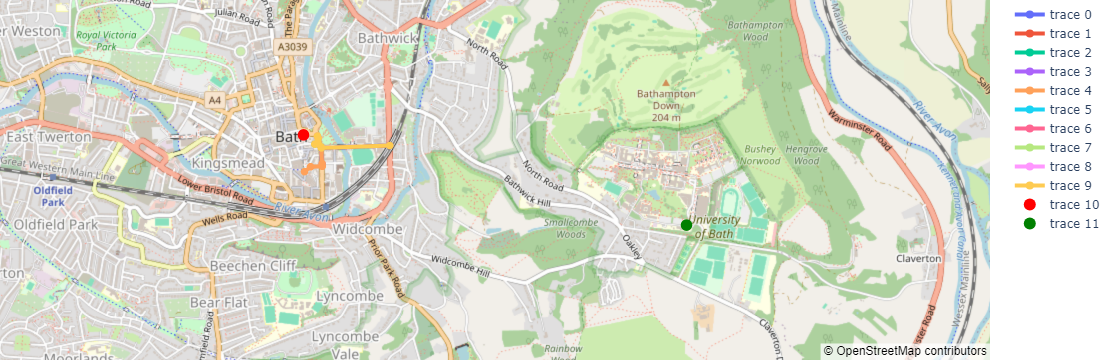

In [20]:
import osmnx as ox
import numpy as np
import plotly.graph_objects as go
import random

def download_and_create_graph():
    # Adjust to cover the area of interest
     north, south, east, west = 51.3815, 51.37667, -2.3587, -2.32583

     # Use the bbox parameter with a tuple containing (north, south, east, west)
     G = ox.graph_from_bbox(bbox=(north, south, east, west), network_type='drive')

     return G

def simulate_hmm_path(G, start_node, end_node, path_length=10):
    """Simulates path generation, mimicking an HMM-like process."""
    path = [start_node]
    for _ in range(path_length - 1):
        current_node = path[-1]
        neighbors = list(G.neighbors(current_node))
        if end_node in neighbors:
            path.append(end_node)  # Directly append end_node if it's a neighbor
            break
        next_node = random.choice(neighbors) if neighbors else current_node
        path.append(next_node)
    return path
    
def plot_paths(G, paths, origin_point, destination_point):
    fig = go.Figure()
    for path in paths:
        long, lat = zip(*[(G.nodes[node]['x'], G.nodes[node]['y']) for node in path])
        # Increase line width here
        fig.add_trace(go.Scattermapbox(mode="lines+markers", lon=long, lat=lat, marker={'size': 8}, line={'width': 4}))
    # Adding markers for the origin and destination points
    fig.add_trace(go.Scattermapbox(mode="markers", lon=[origin_point[1]], lat=[origin_point[0]], marker={'size': 12, 'color': "red"}))
    fig.add_trace(go.Scattermapbox(mode="markers", lon=[destination_point[1]], lat=[destination_point[0]], marker={'size': 12, 'color': 'green'}))
    
    # Set map center and zoom level
    fig.update_layout(mapbox_style="open-street-map", mapbox_zoom=13, mapbox_center={"lat": np.mean([origin_point[0], destination_point[0]]), "lon": np.mean([origin_point[1], destination_point[1]])})
    
    # Remove margin around the plot
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

def main():

    origin_point = (51.3815, -2.3587)  # Southwest corner (latitude, longitude)
    destination_point = (51.37667, -2.32583)  # Northeast corner
    G = download_and_create_graph()
    start_node = ox.distance.nearest_nodes(G, origin_point[1], origin_point[0])
    end_node = ox.distance.nearest_nodes(G, destination_point[1], destination_point[0])
    paths = [simulate_hmm_path(G, start_node, end_node, path_length=10) for _ in range(10)]  # Generate 5 simulated paths

    
    plot_paths(G, paths, origin_point, destination_point)

main()
